# Introduction to Multiplexed Gradient Descent (MGD)
In an era of emerging specialized neuromorphic hardware, the demand for backprop-free gradient descent is more than ever. MGD is a perturbative method that offers a simple and efficient path to training arbitrary networks with respect to an objective function, so long as a gradient exists.  This notebook is a minimal example toward a practical understanding of MGD. A few things to note:
 - We utilize the JAX python package for flexible and efficient neural network operations
 - Where ever the @jax.jit is used, the function that follows will be subject to "just in time" compilation
 - JAX requires explicit seed (random key) definitions.  Where ever a key is defined, simply think of that as a seed.
 - This can simply be thought of as preparing (compiling) the function to be used efficiently
 - We otherwise avoid obfuscating our implementation with calls to pacakages like jax.flax are even more efficent, but opaque

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import copy

import src.utils.helper_functions as hf
import src.data_loader as dat

## To Start: Initialize (any) network
 - MGD is model-free and therefore indifferent to network topology, activation function, and node variation. 
 - We here implement a simple multi-layer feedforward neural network (an MLP).
 - In the recurrent tutorial, we examine more varied topologies.

In [2]:
def init_MLP(layer_sizes, key, scale=1e-2):
    """
    Initializes weights and biases for a fully connected MLP.

    Args:
        layer_sizes (List[int]): List of integers specifying the number of units in each layer.
                                 For example, [784, 256, 10] creates two layers: 784→256 and 256→10.
        key (jax.random.PRNGKey): PRNG key for generating random weights.
        scale (float): Scaling factor for the initial weights. Defaults to 1e-2.

    Returns:
        List[Dict[str, jnp.ndarray]]: A list of parameter dictionaries, one for each layer,
        where each dictionary has:
            - 'w': weight matrix of shape (input_dim, output_dim)
            - 'b': bias vector of shape (output_dim,)
    """
    keys = jax.random.split(key, len(layer_sizes) - 1)
    mlp = []
    for in_dim, out_dim, k in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        w_key, b_key = jax.random.split(k)
        weights = jnp.sqrt(2/in_dim) * jax.random.normal(w_key, (in_dim, out_dim))
        biases = jnp.zeros((out_dim,))
        mlp.append({'weights': weights, 'biases': biases})
    return mlp

key = jax.random.PRNGKey(1, impl=None)
neural_net = init_MLP([784,128,10], key, scale=.1)

## 1. Make a (totally normal) foward pass
- The forward pass for MGD is exactly like any old MLP forward pass

In [3]:
@jax.jit
def forward_MLP(X, readout):
    """
    Performs a forward pass through a multi-layer perceptron (MLP) readout with ReLU activations
    and a final linear output layer. Assumes layers are stored in a list of parameter dictionaries.

    Args:
        X (jnp.ndarray): Input array of shape (batch_size, input_dim).
        readout (List[Dict[str, jnp.ndarray]]): List of layer parameter dictionaries.
            Each dictionary must contain:
                - 'weights': weight matrix of shape (in_dim, out_dim)
                - 'biases': bias vector of shape (out_dim,)
            The list should contain one or more hidden layers followed by the final output layer.

    Returns:
        jnp.ndarray: Output of the MLP after the final linear transformation,
                     shape (batch_size, output_dim).
    """
    *hidden, last = readout
    for layer in hidden:
        X = jax.nn.relu(X @ layer['weights'] + layer['biases'])
    return X @ last['weights'] + last['biases'] 

We'll need som data to feed into the network. Let's load MNIST.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow_datasets as tfds
data_dir = '/tmp/tfds'
mnist_data, info = tfds.load(
    name="mnist", 
    batch_size=1, data_dir=data_dir, with_info=True
    )
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
X_train = jnp.array([x.flatten()/255 for x in train_data['image']])
y_train = jax.nn.one_hot(train_data['label'],10)
X_test  = jnp.array([x.flatten()/255 for x in test_data['image']])
y_test  = jax.nn.one_hot(test_data['label'],10)

And feed it to our network...

In [5]:
logits = forward_MLP(X_train[0], neural_net)
print(f"Activation at final each neuron in the final layer of network: \n{logits}")

Activation at final each neuron in the final layer of network: 
[-1.2312608  -0.06178296 -0.01688387 -0.26757982 -0.4327068   0.6410849
  0.23791422 -0.06920224  0.09453575  0.5195744 ]


Finally, like with any forward pass, we determine the loss with respect to our objective function.  Here, we use cross-entropy.

In [6]:
import optax
@jax.jit
def loss_CE(logits, labels):
    # log_softmax_probs = jax.nn.log_softmax(logits, axis=-1)
    # per_example_loss = -jnp.sum(labels * log_softmax_probs, axis=-1) 
    # return jnp.mean(per_example_loss)
    return optax.softmax_cross_entropy(logits=logits, labels=labels).mean()

cost0 = loss_CE(logits, y_train[0])
print(f"Forward pass cost: \n{cost0}")

Forward pass cost: 
2.7850327491760254


## 2. Perturb all learnable parameters simultaneously
 - Select some (small) value $\epsilon$
 - Random perturb all learnable parameters by $\pm \epsilon$
 - Store those perturbation values for every parameter
 - Apply those perturbations to a copy of the original parametes
   - In hardware, there would be no copying. The pert value would just be stored locally.

In [7]:
@jax.jit
def sample_perturbations(params,epsilon,i):
    key = jax.random.PRNGKey(i, impl=None)
    return jax.tree.map(
        lambda p: jax.random.choice(key, jnp.array([-1,1])*epsilon, shape=(p.shape)), params
    )

@jax.jit
def apply_perturbations(theta,perturbations):
    return jax.tree.map(lambda param, pert: param+pert, theta, perturbations)

epsilon = 0.000001

# create a set of epsilon-sized perturbations for given the shape of parameters
perturbations = sample_perturbations(neural_net,epsilon,0)

# # create a copy of the original network (this is just for easy coding, not fundamental to MGD)
# neural_net_copy = copy.deepcopy(neural_net)

# apply perturbations to copy
neural_net_perturbed = apply_perturbations(neural_net,perturbations)

## 3. Perform forward pass (again), but now with perturbed parameters
 - You'll notice these results are not exactly equivalent to the originals.

In [8]:
logits_perturbed = forward_MLP(X_train[0], neural_net_perturbed)
cost_perturbed   = loss_CE(logits_perturbed, y_train[0])

print(f"Activation at final each neuron in the final layer of perturbed network: \n{logits_perturbed}")
print(f"Perturbed forward pass cost: \n{cost_perturbed}")

Activation at final each neuron in the final layer of perturbed network: 
[-1.2312444  -0.06178118 -0.01688914 -0.2675837  -0.432705    0.6411003
  0.23791862 -0.06921027  0.09453714  0.5195775 ]
Perturbed forward pass cost: 
2.7850341796875


## 4. Collect the gradient
 - Collect the gradient at every parameter
 - Defined simple as the difference in orginal and perturbed cost, weighted by learning rate
 - A good default learning rate is $\eta = 1/\epsilon^2$

In [9]:
@jax.jit
def init_grad(params):
    return jax.tree.map(lambda p: jnp.zeros(shape=(p.shape)), params)

@jax.jit
def collect_grad(perts,delta_c,G):
    return jax.tree.map(lambda G, p: G + p*delta_c, G, perts)

delta_cost = cost_perturbed - cost0
gradient = init_grad(neural_net)
gradient = collect_grad(perturbations, delta_cost, gradient)

## 5. Update parameters
 - Simply apply this gradient to every parameter component-wise
 - Weight update by $\tau_\theta$ (the number of iterations for which the gradient was collected)
   - Analogous to batch size
   - In this case $\tau_\theta=1$

In [10]:
@jax.jit
def MGD_update(params,G,eta,tau_theta):
    return jax.tree.map(
        lambda p, G: p - G*eta/tau_theta, params, G
    )

eta = 1/epsilon**2
tau_theta = 1
neural_net = MGD_update(neural_net,gradient,eta,tau_theta)

## That's it! Now just repeat
 - Everything else about learning is analogous to the backprop procedure
 - However, importantly, a sophisticated gradient calculation, weight transport, and network model are *not* needed
 - Instead, two forward passes, local short-term storage of perturbations, and one global broadcase are used
 - That's it!

In [11]:
# # neural_net_copy 
#     if i>1: hf.print_clean_tree(hf.tree_diff(perturbations,last_perts))
#     last_perts = copy.deepcopy(perturbations)

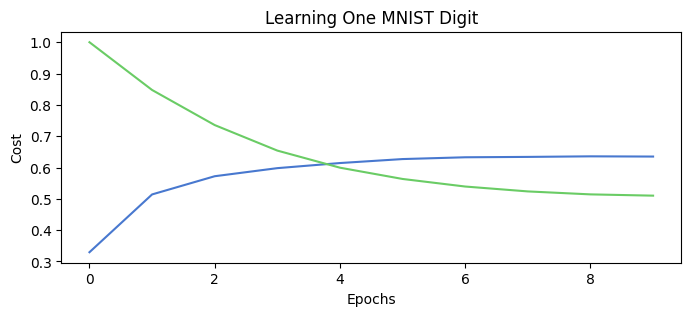

In [47]:
epochs = 10
costs      = []
accs       = []

epsilon = 0.000001
net_dims = [784,128,10]

batch_size=tau_theta=128

K = np.prod(net_dims) + np.sum(net_dims[1:])

eta0 =  10000 / (epsilon**2 * np.sqrt(K) * np.sqrt(1+(K-1)/tau_theta))
decay = .1
key = jax.random.PRNGKey(1, impl=None)
neural_net = init_MLP(net_dims, key, scale=1)
params_before = copy.deepcopy(neural_net)

for epoch in range(epochs):
    epoch_costs = []
    eta = eta0/(1+decay*epoch)
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        # Step 1: Forward pass
        logits = forward_MLP(X_batch, neural_net)
        cost0  = loss_CE(logits, y_batch)
        epoch_costs.append(cost0)

        # Step 2: Perturb
        perturbations        = sample_perturbations(neural_net,epsilon,i)
        neural_net_perturbed = apply_perturbations(neural_net,perturbations)

        # Step 3: Perturbed forward pass
        logits_perturbed = forward_MLP(X_batch, neural_net_perturbed)
        cost_perturbed   = loss_CE(logits_perturbed, y_batch)

        # Step 4: Collect gradient
        delta_cost = (cost_perturbed - cost0)*1
        gradient   = init_grad(neural_net)
        gradient   = collect_grad(perturbations, delta_cost, gradient)
        
        # Step 5: Make update
        before_update = copy.deepcopy(neural_net)
        neural_net = MGD_update(neural_net,gradient,eta,tau_theta)
    costs.append(np.mean(epoch_costs))
    accs.append(
        jnp.mean(
            jnp.argmax(forward_MLP(X_test, neural_net),axis=-1)==
            jnp.argmax(y_test,axis=-1)
            ))

plt.style.use('seaborn-v0_8-muted')
plt.figure(figsize=(8,3))
plt.plot(accs)
plt.plot(costs/np.max(costs))
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Learning One MNIST Digit")
plt.show()